In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

# setting parameters for image displays all over
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
# df = pd.read_csv('D:\Datasets\wind_speed.csv')
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/BE_Datasets/'

df = pd.read_csv(root_path + '10_Year_WindDataset.csv')
print(df.head())

In [ ]:
df.head

<bound method NDFrame.head of              Location  Wind Direction  ...  Pressure        Conditions
0     Pune, MH, India           80.00  ...    1012.7             Clear
1     Pune, MH, India          102.50  ...    1013.9             Clear
2     Pune, MH, India          180.00  ...    1014.1             Clear
3     Pune, MH, India          230.00  ...    1013.1             Clear
4     Pune, MH, India           90.00  ...    1011.8             Clear
...               ...             ...  ...       ...               ...
3753  Pune, MH, India          180.00  ...    1010.3  Partially cloudy
3754  Pune, MH, India          160.17  ...    1009.9  Partially cloudy
3755  Pune, MH, India          142.00  ...    1008.3  Partially cloudy
3756  Pune, MH, India          122.20  ...    1008.4       Rain, Clear
3757  Pune, MH, India          175.33  ...    1009.1  Partially cloudy

[3758 rows x 16 columns]>

In [ ]:
Train_split = 1000

In [ ]:
tf.random.set_seed = 15

In [ ]:
uni_data = df['Wind Speed']
uni_data.index = df['Datetime']
uni_data.head()

Datetime
01/01/2010    2.2
01/02/2010    5.8
01/03/2010    2.2
01/04/2010    2.2
01/05/2010    3.4
Name: Wind Speed, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe05dd413c8>],
      dtype=object)

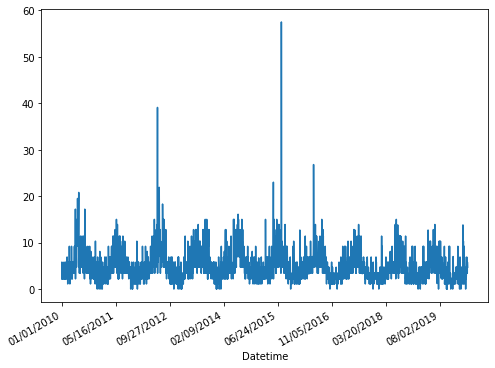

In [ ]:
uni_data.plot(subplots = True)

In [ ]:
uni_data = uni_data.values

In [ ]:
#uni_train_min = uni_data[:Train_split].min()
#uni_train_max = uni_data[:Train_split].max()

In [ ]:
#uni_data[:Train_split] = (uni_data[:Train_split]-uni_train_min)/(uni_train_max-uni_train_min)

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data=[]
    labels=[]

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, Train_split,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, Train_split, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target wind speed to predict')
print (y_train_uni[0])

Single window of past history
[[2.2]
 [5.8]
 [2.2]
 [2.2]
 [3.4]
 [4.7]
 [4.7]
 [2.2]
 [3.4]
 [4.7]
 [3.4]
 [3.4]
 [4.7]
 [4.7]
 [4.7]
 [2.2]
 [2.2]
 [4.7]
 [4.7]
 [2.2]]

 Target wind speed to predict
3.4


In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

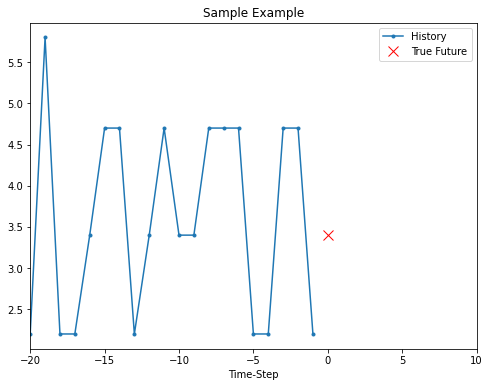

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [ ]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

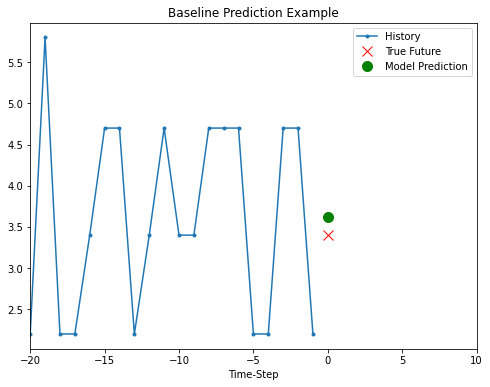

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 100

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
adam = keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, amsgrad=False)
simple_lstm_model.compile(optimizer = 'adam', loss='mean_squared_logarithmic_error')

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(64, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2827 - val_loss: 0.1399
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1596 - val_loss: 0.1350
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1539 - val_loss: 0.1330
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1499 - val_loss: 0.1317
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1494 - val_loss: 0.1324
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1457 - val_loss: 0.1311
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1476 - val_loss: 0.1316
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1448 - val_loss: 0.1307
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1441 - val_loss: 0.1333
Epoch 10/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1448 - val_lo

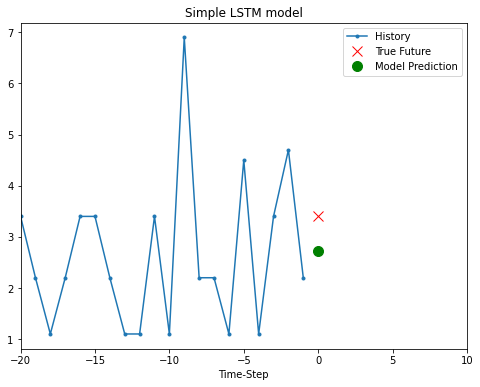

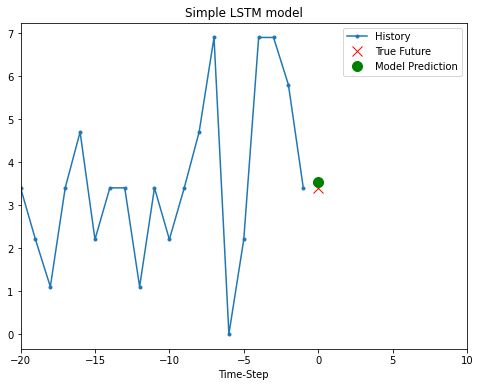

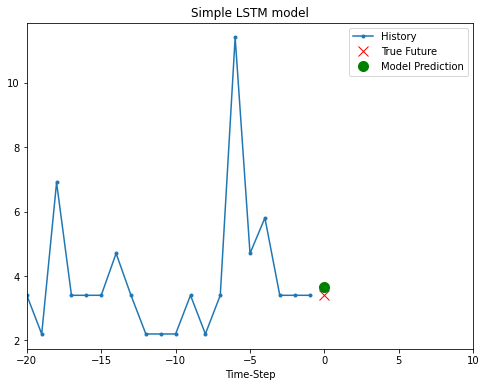

In [ ]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [ ]:
print(simple_lstm_model.input_shape)

(None, 20, 1)


In [ ]:
uni_data.shape

(3758,)

In [ ]:
prediction_for = uni_data[1000:,]
prediction_for.shape

(2758,)

In [ ]:
#prediction_for = prediction_for.reshape(1,298,1)

In [ ]:
final_predictions =[None] * 1298
for i in range(1,1278):
    temp_array = uni_data[i:i+20,]
    temp_array = temp_array.reshape(1,20,1)
    ans = simple_lstm_model.predict(temp_array)
    final_predictions[i] = ans

In [ ]:
final_predictions = np.asarray(final_predictions)

In [ ]:
final_predictions.shape

(1298,)

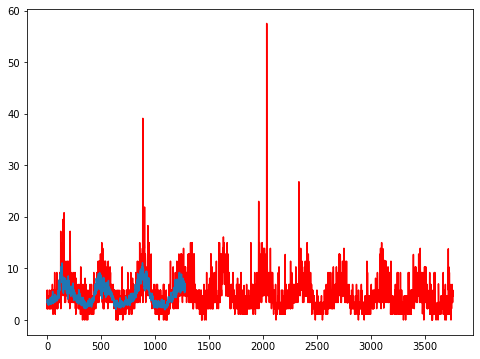

In [ ]:
plt.plot(uni_data, color ='red')
plt.plot(final_predictions)

In [ ]:
predicted_wind_speed = simple_lstm_model.predict(val_univariate, steps = 1)

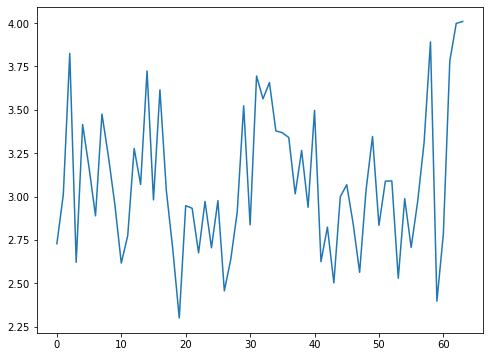

In [ ]:
plt.plot(predicted_wind_speed)